# Atividade 1: Redes Neurais

In [ ]:
import torch
from torch import nn
from torchvision import datasets, transforms

import seaborn as sns
import matplotlib.pyplot as plt

# Base de dados MNIST

## Carregamento dos dados

In [ ]:
import torchvision.transforms as T

# carregamento inicial sem normalização

tensor_train = datasets.MNIST(
    root="/content/drive/MyDrive/datasets",
    train=True,
    download=True,
    transform=T.ToTensor()
)

tensor_test = datasets.MNIST(
    root="/content/drive/MyDrive/datasets",
    train=False,
    download=True,
    transform=T.ToTensor()
)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting /content/drive/MyDrive/datasets/MNIST/raw/train-images-idx3-ubyte.gz to /content/drive/MyDrive/datasets/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting /content/drive/MyDrive/datasets/MNIST/raw/train-labels-idx1-ubyte.gz to /content/drive/MyDrive/datasets/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting /content/drive/MyDrive/datasets/MNIST/raw/t10k-images-idx3-ubyte.gz to /content/drive/MyDrive/datasets/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting /content/drive/MyDrive/datasets/MNIST/raw/t10k-labels-idx1-ubyte.gz to /content/drive/MyDrive/datasets/MNIST/raw



## Quantas amostras estão nos dados de treino e teste?

In [ ]:
# Quantidade de amostras nos dados de treino

print(tensor_train)
print(f'\nQuantidade de amostras nos dados de treino: {len(tensor_train.data)}')

Dataset MNIST
    Number of datapoints: 60000
    Root location: /content/drive/MyDrive/datasets
    Split: Train
    StandardTransform
Transform: ToTensor()

Quantidade de amostras nos dados de treino: 60000


In [ ]:
# Quantidade de amostras nos dados de teste

print(tensor_test)
print(f'\nQuantidade de amostras nos dados de teste: {len(tensor_test.data)}')

Dataset MNIST
    Number of datapoints: 10000
    Root location: /content/drive/MyDrive/datasets
    Split: Test
    StandardTransform
Transform: ToTensor()

Quantidade de amostras nos dados de teste: 10000


## Plotar algumas amostras (e.g. 9, 16, 25) num grid (e.g. 3 x 3, 4 x 4 ou 5 x 5) usando plt.imshow.

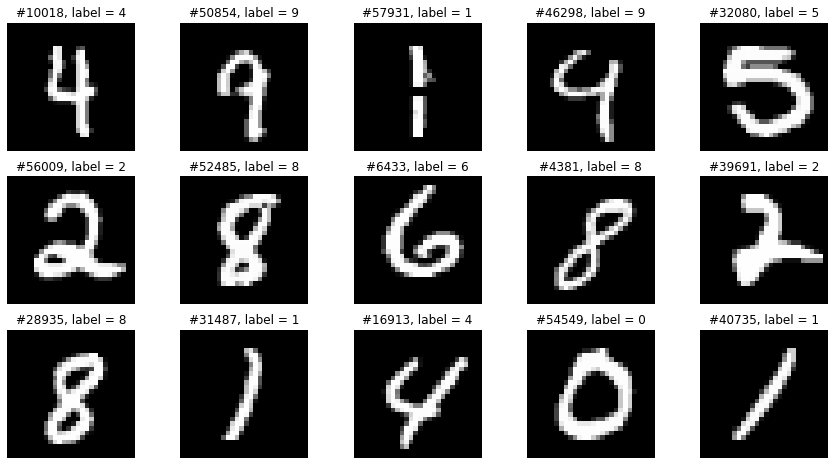

In [ ]:
figure = plt.figure(figsize=(15, 8))
cols, rows = 5, 3
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(tensor_train), size=(1,)).item()
    img, label = tensor_train[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(f'#{sample_idx}, label = {label}')
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")
plt.show()

## Em qual formato vem os dados (shape, tipo de dados)?

In [ ]:
# shape

print(f'Shape do conjunto de treino: {tensor_train.data.shape}')
print(f'Shape de cada elemento do conjunto de treino: {tensor_train.data[0].shape}')

Shape do conjunto de treino: torch.Size([60000, 28, 28])
Shape de cada elemento do conjunto de treino: torch.Size([28, 28])


In [ ]:
# tipo

print(f'Tipo do conjunto de treino/teste: {tensor_train.data.type()}')
print(f'Tipo de cada elemento do conjunto de treino/teste: {tensor_train.data[0].type()}')
print(f'Tipo dos pixels: {tensor_train.data.dtype}')

Tipo do conjunto de treino/teste: torch.ByteTensor
Tipo de cada elemento do conjunto de treino/teste: torch.ByteTensor
Tipo dos pixels: torch.uint8


## Normalização

In [ ]:
# cálculo da média e do desvio padrão

imgs = torch.stack([img_t for img_t, _ in tensor_train], dim=3)
imgs_mean = imgs.view(1, -1).mean(dim=1).item()
imgs_std = imgs.view(1, -1).std(dim=1).item()

# definição do transform

prep_transform = T.Compose(
    [
     T.ToTensor(),
     T.Normalize(mean=imgs_mean, std=imgs_std)
    ]
)

# carregamento normalizado

tensor_train = datasets.MNIST(
    root="/content/drive/MyDrive/datasets",
    train=True,
    download=True,
    transform=prep_transform
)

tensor_test = datasets.MNIST(
    root="/content/drive/MyDrive/datasets",
    train=False,
    download=True,
    transform=prep_transform
)

In [ ]:
# DataLoaders

from torch.utils.data import DataLoader

batch_size = 64
train_loader = DataLoader(tensor_train, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(tensor_test, batch_size=batch_size, shuffle=True)

# Least Squares

## Modelo

In [ ]:
class LeastSquaresModel():
  def fit(self, X, y):
    self.θ = torch.matmul(torch.matmul(torch.linalg.pinv(torch.matmul(X.T, X)), X.T), y)
    self.b = torch.mean(y, dim=0) - torch.matmul(self.θ.T, torch.mean(X, dim=0))
    
  def predict(self, X):
    yhat = torch.matmul(X, self.θ) + self.b
    return yhat

## Treino

In [ ]:
import time


X_train_ls = torch.flatten(tensor_train.data, start_dim=1).float()
y_train_ls = torch.nn.functional.one_hot(tensor_train.targets, num_classes= 10).float()

X_test_ls = torch.flatten(tensor_test.data, start_dim=1).float()
y_test_ls = torch.nn.functional.one_hot(tensor_test.targets, num_classes= 10).float()

least_square_model = LeastSquaresModel()

start_time = time.time()
least_square_model.fit(X_train_ls, y_train_ls)
pred_ls = least_square_model.predict(X_test_ls)
print(f'tempo total: {time.time() - start_time:.2f} segundos')

tempo total: 2.76 segundos


## Análise

In [ ]:
import sklearn.metrics

def plot_confusion_matrix(cmat, list_of_classes):
  ax = sns.heatmap(cmat.astype(int), annot=True, fmt='g')

  _ = ax.set_xticklabels(list_of_classes)
  _ = ax.set_yticklabels(list_of_classes, rotation=90)

  ax.set_ylabel('Classe Real')
  ax.set_xlabel('Classe Predita')


def my_accuracy_score(confusion_matrix):

  total_correct = 0.0
  total_prediction = 0.0

  n_classes = len(confusion_matrix[0])
  for i in range(n_classes):
    correct_count = confusion_matrix[i][i]
    class_pred = sum(confusion_matrix[i])

    total_correct += correct_count
    total_prediction += class_pred
    
    accuracy = 100 * float(correct_count) / class_pred

    print(f'Acurácia para a classe {i}: {accuracy:.1f} %')
  print("Acurácia global {:.1f}%".format(100 * total_correct/total_prediction))

### Matriz de confusão

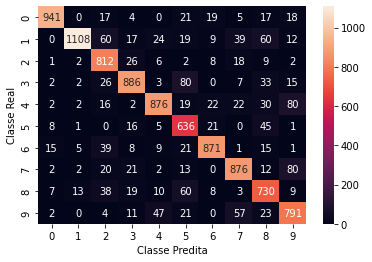

In [ ]:
cmat = sklearn.metrics.confusion_matrix(pred_ls.argmax(-1), y_test_ls.argmax(-1))
plot_confusion_matrix(cmat, ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9'])

### Acurácia

In [ ]:
my_accuracy_score(cmat)

Acurácia para a classe 0: 90.3 %
Acurácia para a classe 1: 82.2 %
Acurácia para a classe 2: 91.6 %
Acurácia para a classe 3: 84.1 %
Acurácia para a classe 4: 81.8 %
Acurácia para a classe 5: 86.8 %
Acurácia para a classe 6: 88.4 %
Acurácia para a classe 7: 85.2 %
Acurácia para a classe 8: 81.4 %
Acurácia para a classe 9: 82.7 %
Acurácia global 85.3%


### Visualização de 𝜃

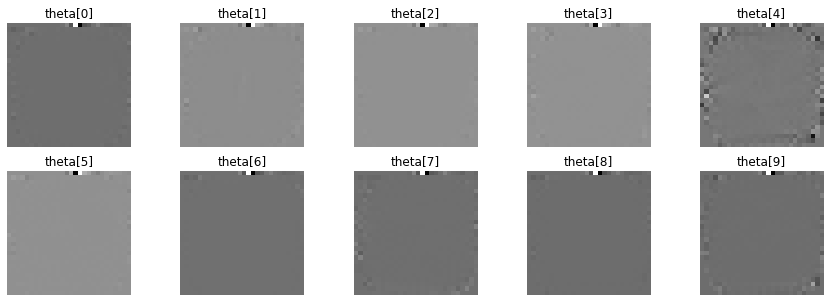

In [ ]:
import numpy as np

def normalize_scale(input):
  output = (input - np.min(input, axis=0)) / (np.max(input, axis=0) - np.min(input, axis=0))
  return output

figure = plt.figure(figsize=(15, 5))
cols, rows = 5, 2
for i in range(0, cols * rows):

  𝜃_i = least_square_model.𝜃.T[i].numpy()
  𝜃_i = normalize_scale(𝜃_i)
  𝜃_i = np.reshape(𝜃_i, newshape=(28,28))
    
    
  figure.add_subplot(rows, cols, i+1)
  plt.title(f'theta[{i}]')
  plt.axis("off")
  plt.imshow(𝜃_i, cmap='gray', vmin=0, vmax=1)
plt.show()

# Logistic Regression

## Modelo

In [ ]:
class LogisticRegression(torch.nn.Module):
  def __init__(self):
    super(LogisticRegression, self).__init__()
    self.layer1 = torch.nn.Linear(28*28, 10)
    self.softmax = torch.nn.Softmax(dim=1)
    self.flatten = nn.Flatten()
  
  def forward(self, x):
    v = self.flatten(x)
    logit = self.layer1(v)
    yhat = self.softmax(logit)
    return yhat

## Treino

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'Rodando na {device}')

Rodando na cpu


In [ ]:
logistic_regression_model = LogisticRegression().to(device)

In [ ]:
# hiperparâmetros

optimizer = torch.optim.Adam(logistic_regression_model.parameters(), lr=0.001)
loss_func = nn.CrossEntropyLoss()

In [ ]:
# função de treino

def train(model, dataloader, lossfunc, optimizer):
  model.train()
  cumloss = 0.0
  correct = 0
  iterations = 0
  for imgs, labels in dataloader:
    imgs, labels = imgs.to(device), labels.to(device)
    iterations += 1

    pred = model(imgs)
    loss = lossfunc(pred, labels)

    # zera os gradientes acumulados
    optimizer.zero_grad()
    # computa os gradientes
    loss.backward()
    # anda na direção que reduz o erro local
    optimizer.step()

    # loss é um tensor; item para obter o float
    cumloss += loss.item()
    correct += (pred.argmax(-1) == labels).float().sum()

  accuracy = correct / (len(dataloader) * dataloader.batch_size)
  batch_loss = cumloss / len(dataloader)
  
  return batch_loss, accuracy

In [ ]:
# função de validação

def validate(model, dataloader, lossfunc):
  model.eval()
  cumloss = 0.0
  correct = 0

  with torch.no_grad():
    for imgs, labels in dataloader:
      imgs, labels = imgs.to(device), labels.to(device)

      pred = model(imgs)
      loss = lossfunc(pred, labels)
      cumloss += loss.item()
      correct += (pred.argmax(-1) == labels).float().sum()
  
  accuracy = correct / (len(dataloader) * dataloader.batch_size)
  batch_loss = cumloss / len(dataloader)

  return batch_loss, accuracy

In [ ]:
# treinamento

import time
start_time = time.time()

print(f'Device: {device}')

epochs = 51

train_losses = []
test_losses = []

train_accs = []
test_accs = []

for t in range(epochs):
  train_loss, train_acc = train(logistic_regression_model, train_loader, loss_func, optimizer)
  train_losses.append(train_loss)
  train_accs.append(train_acc)
  if t % 5 == 0:
    print(f'Epoch: {t}; Train Loss: {train_loss:.2f}; Train Acc: {train_acc:.2f}; time = {time.time() - start_time:.2f}')
  test_loss, test_acc = validate(logistic_regression_model, test_loader, loss_func)
  test_losses.append(test_loss)
  test_accs.append(test_acc)
print(f'tempo total: {time.time() - start_time:.2f} segundos')

Device: cpu
Epoch: 0; Train Loss: 1.61; Train Acc: 0.88; time = 10.59
Epoch: 5; Train Loss: 1.54; Train Acc: 0.93; time = 70.55
Epoch: 10; Train Loss: 1.53; Train Acc: 0.94; time = 131.17
Epoch: 15; Train Loss: 1.53; Train Acc: 0.94; time = 193.67
Epoch: 20; Train Loss: 1.52; Train Acc: 0.94; time = 254.59
Epoch: 25; Train Loss: 1.52; Train Acc: 0.94; time = 315.23
Epoch: 30; Train Loss: 1.52; Train Acc: 0.94; time = 377.19
Epoch: 35; Train Loss: 1.52; Train Acc: 0.95; time = 439.95
Epoch: 40; Train Loss: 1.52; Train Acc: 0.95; time = 501.29
Epoch: 45; Train Loss: 1.52; Train Acc: 0.95; time = 561.83
Epoch: 50; Train Loss: 1.52; Train Acc: 0.95; time = 622.18
tempo total: 623.77 segundos


## Análise

### Curvas de aprendizagem

In [ ]:
def plot_losses(losses):
  fig = plt.figure(figsize=(13, 5))
  ax = fig.gca()
  for loss_name, loss_values in losses.items():
    ax.plot(loss_values, label=loss_name)
  ax.legend(fontsize='16')
  ax.set_xlabel('Iteration', fontsize='16')
  ax.set_ylabel('Loss', fontsize='16')
  ax.set_title('Loss vs iterations', fontsize='16')

def plot_accuracy(acc_history):
  fig = plt.figure(figsize=(13, 5))
  ax = fig.gca()
  for acc_name, acc_values in acc_history.items():
    ax.plot(acc_values, label=acc_name)
  ax.legend(fontsize='16')
  ax.set_xlabel('Iteration', fontsize='16')
  ax.set_ylabel('Accuracy', fontsize='16')
  ax.set_title('Accuracy vs iterations', fontsize='16')

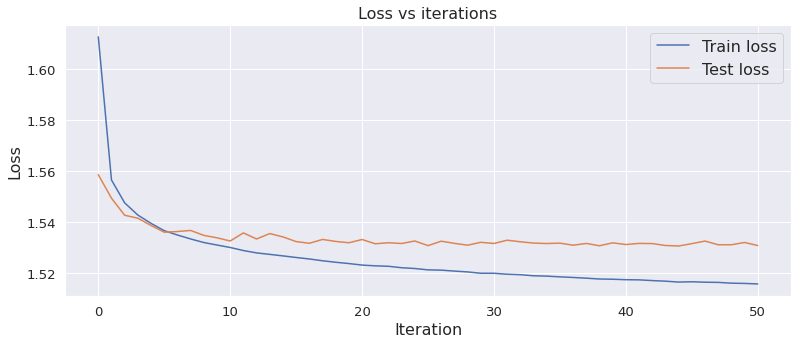

In [ ]:
losses = {'Train loss': train_losses, 'Test loss': test_losses}
plot_losses(losses)

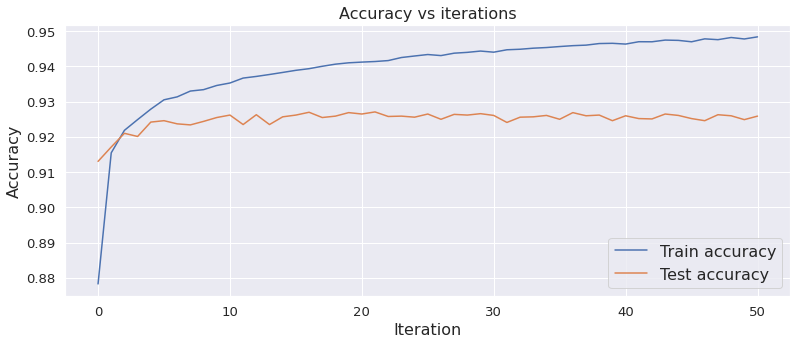

In [ ]:
acc_history = {'Train accuracy': train_accs, 'Test accuracy': test_accs}
plot_accuracy(acc_history)

### Matriz de confusão

In [ ]:
def make_confusion_matrix(model, loader, n_classes):
  confusion_matrix = torch.zeros(n_classes, n_classes, dtype=torch.int64)
  with torch.no_grad():
    for i, (imgs, labels) in enumerate(loader):
      imgs = imgs.to(device)
      labels = labels.to(device)
      outputs = model(imgs)
      _, predicted = torch.max(outputs, 1)
      for t, p in zip(torch.as_tensor(labels, dtype=torch.int64).view(-1), 
                      torch.as_tensor(predicted, dtype=torch.int64).view(-1)):
        confusion_matrix[t, p] += 1
  return confusion_matrix

def evaluate_accuracy(model, dataloader, classes, verbose=True):
  # prepare to count predictions for each class
  correct_pred = {classname: 0 for classname in classes}
  total_pred = {classname: 0 for classname in classes}

  confusion_matrix = make_confusion_matrix(model, dataloader, len(classes))
  if verbose:
    total_correct = 0.0
    total_prediction = 0.0
    for i, classname in enumerate(classes):
      correct_count = confusion_matrix[i][i].item()
      class_pred = torch.sum(confusion_matrix[i]).item()

      total_correct += correct_count
      total_prediction += class_pred

      accuracy = 100 * float(correct_count) / class_pred
      print("Accuracy for class {:5s} is: {:.1f} %".format(classname,
                                                    accuracy))
  print("Global acccuracy is {:.1f}".format(100 * total_correct/total_prediction))

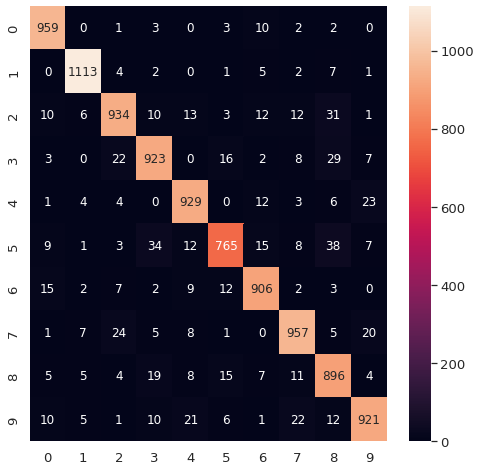

In [ ]:
confusion_matrix = make_confusion_matrix(logistic_regression_model, test_loader, 10)
plt.figure(figsize=(8, 8))
sns.set(font_scale=1.2)
sns.heatmap(confusion_matrix.tolist(),
            annot=True, 
            annot_kws={"size": 12}, 
            fmt='d')

### Acurácia

In [ ]:
evaluate_accuracy(logistic_regression_model, test_loader, ['0','1','2','3','4','5','6','7','8','9'])

Accuracy for class 0     is: 97.9 %
Accuracy for class 1     is: 98.1 %
Accuracy for class 2     is: 90.5 %
Accuracy for class 3     is: 91.4 %
Accuracy for class 4     is: 94.6 %
Accuracy for class 5     is: 85.8 %
Accuracy for class 6     is: 94.6 %
Accuracy for class 7     is: 93.1 %
Accuracy for class 8     is: 92.0 %
Accuracy for class 9     is: 91.3 %
Global acccuracy is 93.0


### Visualização de $\theta$

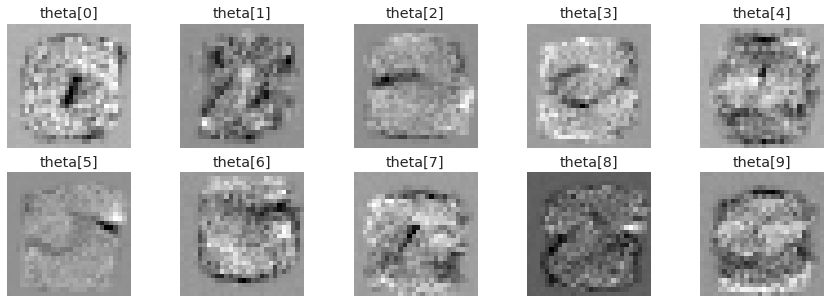

In [ ]:
import numpy as np

def normalize_scale(input):
  output = (input - np.min(input, axis=0)) / (np.max(input, axis=0) - np.min(input, axis=0))
  return output

parameters = torch.nn.utils.parameters_to_vector(logistic_regression_model.parameters())
parameters = parameters.detach().numpy()

figure = plt.figure(figsize=(15, 5))
cols, rows = 5, 2
for i in range(0, cols * rows):

  𝜃_i = np.zeros(28*28)
  k=0
  for j in range(i*28*28,(i+1)*28*28):
    𝜃_i[k] = parameters[j]
    k+=1

  𝜃_i = normalize_scale(𝜃_i)
  𝜃_i = np.reshape(𝜃_i, newshape=(28,28))
    
    
  figure.add_subplot(rows, cols, i+1)
  plt.title(f'theta[{i}]')
  plt.axis("off")
  plt.imshow(𝜃_i, cmap='gray', vmin=0, vmax=1)
plt.show()

# Neural Networks

## Modelo

In [ ]:
class NNClassifier(nn.Module):
  def __init__(self):
    super().__init__()

    self.flatten = nn.Flatten()

    self.layers = nn.Sequential(
        nn.Linear(28*28, 64),
        nn.ReLU(),
        nn.Linear(64, 32),
        nn.ReLU(),
        nn.Linear(32, 16),
        nn.ReLU(),
        nn.Linear(16, 10)
    )
  
  def forward(self, x):
    v = self.flatten(x)
    return self.layers(v)

## Treino

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'Rodando na {device}')

Rodando na cpu


In [ ]:
neural_net_model = NNClassifier().to(device)

nn_optimizer = torch.optim.Adam(neural_net_model.parameters(), lr=0.001)
nn_loss_func = nn.CrossEntropyLoss()

In [ ]:
# treinamento

import time
start_time = time.time()

print(f'Device: {device}')

epochs = 21

train_losses = []
test_losses = []

train_accs = []
test_accs = []

for t in range(epochs):
  train_loss, train_acc = train(neural_net_model, train_loader, nn_loss_func, nn_optimizer)
  train_losses.append(train_loss)
  train_accs.append(train_acc)
  if t % 5 == 0:
    print(f'Epoch: {t}; Train Loss: {train_loss:.2f}; Train Acc: {train_acc:.2f}; time = {time.time() - start_time:.2f}')
  test_loss, test_acc = validate(neural_net_model, test_loader, nn_loss_func)
  test_losses.append(test_loss)
  test_accs.append(test_acc)
print(f'tempo total: {time.time() - start_time:.2f}')

Device: cpu
Epoch: 0; Train Loss: 0.42; Train Acc: 0.87; time = 12.14
Epoch: 5; Train Loss: 0.07; Train Acc: 0.98; time = 80.51
Epoch: 10; Train Loss: 0.04; Train Acc: 0.99; time = 148.79
Epoch: 15; Train Loss: 0.02; Train Acc: 0.99; time = 217.32
Epoch: 20; Train Loss: 0.02; Train Acc: 0.99; time = 285.71
tempo total: 287.36


## Análise

### Curvas de aprendizagem

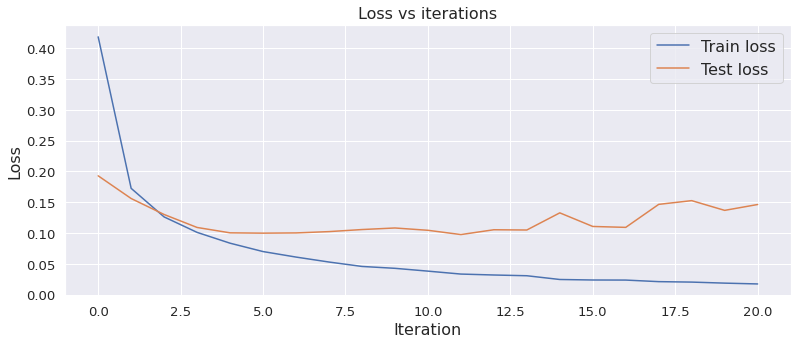

In [ ]:
losses = {'Train loss': train_losses, 'Test loss': test_losses}
plot_losses(losses)

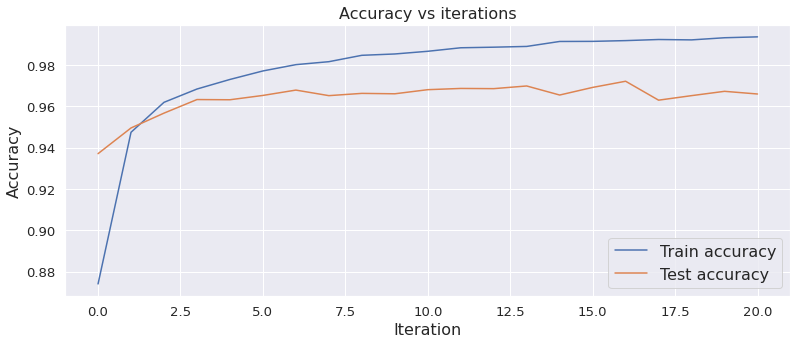

In [ ]:
acc_history = {'Train accuracy': train_accs, 'Test accuracy': test_accs}
plot_accuracy(acc_history)

### Matriz de confusão

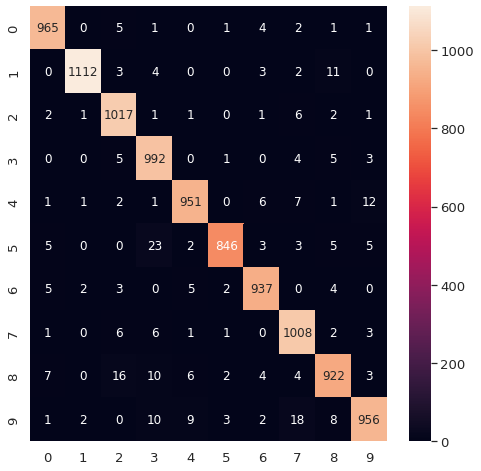

In [ ]:
confusion_matrix = make_confusion_matrix(neural_net_model, test_loader, 10)
plt.figure(figsize=(8, 8))
sns.set(font_scale=1.2)
sns.heatmap(confusion_matrix.tolist(), 
           annot=True, annot_kws={"size": 12}, fmt='d')

### Acurácia

In [ ]:
evaluate_accuracy(neural_net_model, test_loader, ['0','1','2','3','4','5','6','7','8','9'])

Accuracy for class 0     is: 98.5 %
Accuracy for class 1     is: 98.0 %
Accuracy for class 2     is: 98.5 %
Accuracy for class 3     is: 98.2 %
Accuracy for class 4     is: 96.8 %
Accuracy for class 5     is: 94.8 %
Accuracy for class 6     is: 97.8 %
Accuracy for class 7     is: 98.1 %
Accuracy for class 8     is: 94.7 %
Accuracy for class 9     is: 94.7 %
Global acccuracy is 97.1


### Visualização de $\theta$

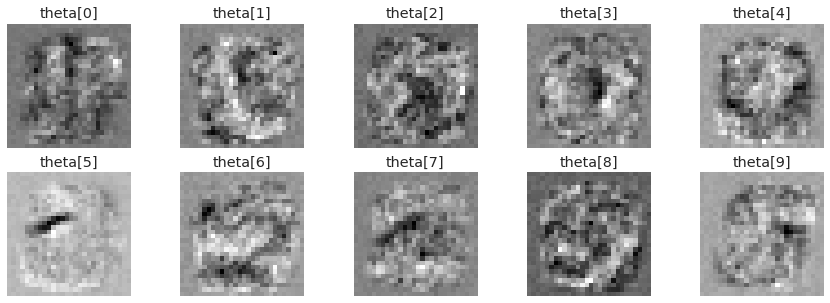

In [ ]:
parameters = torch.nn.utils.parameters_to_vector(neural_net_model.parameters())
parameters = parameters.detach().numpy()

figure = plt.figure(figsize=(15, 5))
cols, rows = 5, 2
for i in range(0, cols * rows):

  𝜃_i = np.zeros(28*28)
  k=0
  for j in range(i*28*28,(i+1)*28*28):
    𝜃_i[k] = parameters[j]
    k+=1

  𝜃_i = normalize_scale(𝜃_i)
  𝜃_i = np.reshape(𝜃_i, newshape=(28,28))
    
    
  figure.add_subplot(rows, cols, i+1)
  plt.title(f'theta[{i}]')
  plt.axis("off")
  plt.imshow(𝜃_i, cmap='gray', vmin=0, vmax=1)
plt.show()

# Exemplos de erros

In [ ]:
def show_error(model, dataloader, s_pred, s_label):
  model.eval()

  with torch.no_grad():
    for imgs, labels in dataloader:
      imgs, labels = imgs.to(device), labels.to(device)
      pred = model(imgs)
      for i in range(len(pred)):
        if pred[i].argmax(-1) == s_pred and labels[i] == s_label:
          return imgs[i]
  return None

Predição incorreta na qual foi predito 4 e o real era 9


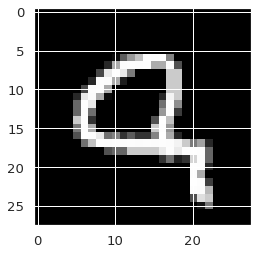

In [ ]:
predito = 4
real = 9

predicao_errada_img = show_error(neural_net_model, test_loader, predito, real)
print(f'Predição incorreta na qual foi predito {predito} e o real era {real}')
plt.imshow(predicao_errada_img[0], cmap='gray');

# Extra: convolutional neural network

## Modelo

In [ ]:
class ConvolutionalModel(nn.Module):
  def __init__(self):
    super().__init__()
    self.convlayers = nn.Sequential(
        nn.Conv2d(1, 8, kernel_size=(3,3)),
        nn.ReLU(),
        nn.MaxPool2d(2, 2),

        nn.Conv2d(8, 16, kernel_size=(3,3)),
        nn.ReLU(),
        nn.MaxPool2d(2, 2)
    )

    self.linearlayers = nn.Sequential(
        nn.Linear(400, 256),
        nn.ReLU(),
        nn.Linear(256, 64),
        nn.ReLU(),
        nn.Linear(64, 10)
    )
  
  def forward(self, x):
    # aprende as features
    x = self.convlayers(x)
    x = torch.flatten(x, 1)
    return self.linearlayers(x)


## Treino

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'Rodando na {device}')

Rodando na cpu


In [ ]:
conv_model = ConvolutionalModel().to(device)

In [ ]:
conv_optimizer = torch.optim.Adam(conv_model.parameters(), lr=0.001)
conv_loss_func = nn.CrossEntropyLoss()

In [ ]:
# treinamento

import time
start_time = time.time()

print(f'Device: {device}')

epochs = 11

train_losses = []
test_losses = []

train_accs = []
test_accs = []

for t in range(epochs):
  train_loss, train_acc = train(conv_model, train_loader, conv_loss_func, conv_optimizer)
  train_losses.append(train_loss)
  train_accs.append(train_acc)
  if t % 5 == 0:
    print(f'Epoch: {t}; Train Loss: {train_loss}; Train Acc: {train_acc}; time = {time.time() - start_time:.2f}')
  test_loss, test_acc = validate(conv_model, test_loader, conv_loss_func)
  test_losses.append(test_loss)
  test_accs.append(test_acc)

Device: cpu
Epoch: 0; Train Loss: 0.22385096236336618; Train Acc: 0.9317030906677246; time = 20.13
Epoch: 5; Train Loss: 0.023556155789358258; Train Acc: 0.9919875860214233; time = 131.44
Epoch: 10; Train Loss: 0.010993558261165753; Train Acc: 0.9958855509757996; time = 242.79


## Análise

### Curvas de aprendizagem

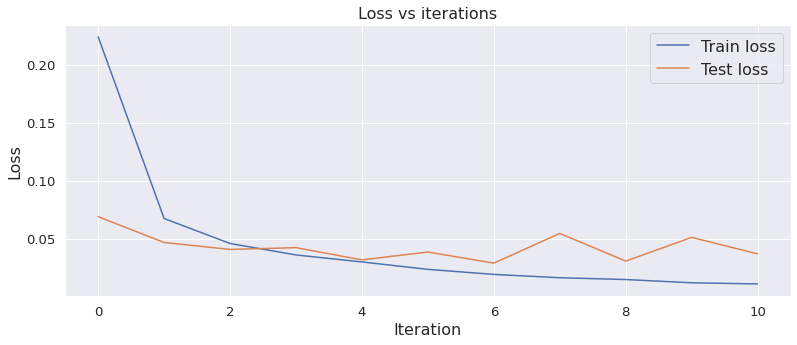

In [ ]:
losses = {'Train loss': train_losses, 'Test loss': test_losses}
plot_losses(losses)

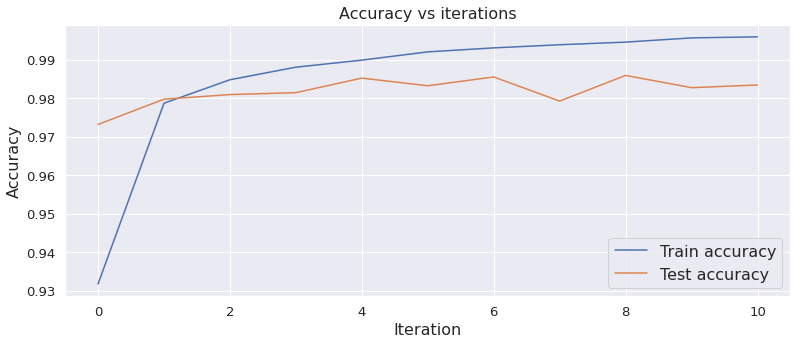

In [ ]:
acc_history = {'Train accuracy': train_accs, 'Test accuracy': test_accs}
plot_accuracy(acc_history)

### Matriz de confusão

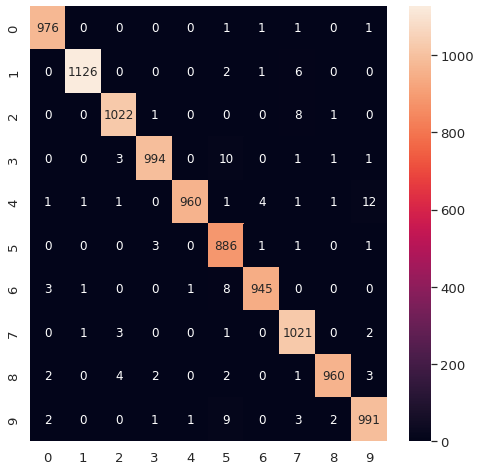

In [ ]:
confusion_matrix = make_confusion_matrix(conv_model, test_loader, 10)
plt.figure(figsize=(8, 8))
sn.set(font_scale=1.2)
sn.heatmap(confusion_matrix.tolist(), 
           annot=True, annot_kws={"size": 12}, fmt='d')

### Acurácia

In [ ]:
evaluate_accuracy(conv_model, test_loader, ['0','1','2','3','4','5','6','7','8','9'])

Accuracy for class 0     is: 99.6 %
Accuracy for class 1     is: 99.2 %
Accuracy for class 2     is: 99.0 %
Accuracy for class 3     is: 98.4 %
Accuracy for class 4     is: 97.8 %
Accuracy for class 5     is: 99.3 %
Accuracy for class 6     is: 98.6 %
Accuracy for class 7     is: 99.3 %
Accuracy for class 8     is: 98.6 %
Accuracy for class 9     is: 98.2 %
Global acccuracy is 98.8


### Visualização de $\theta$

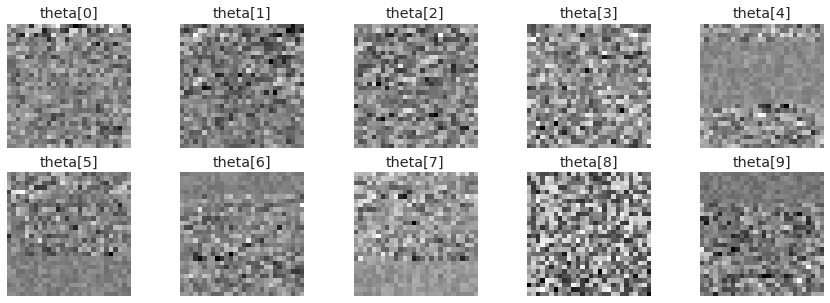

In [ ]:
parameters = torch.nn.utils.parameters_to_vector(conv_model.parameters())
parameters = parameters.detach().numpy()

figure = plt.figure(figsize=(15, 5))
cols, rows = 5, 2
for i in range(0, cols * rows):

  𝜃_i = np.zeros(28*28)
  k=0
  for j in range(i*28*28,(i+1)*28*28):
    𝜃_i[k] = parameters[j]
    k+=1

  𝜃_i = normalize_scale(𝜃_i)
  𝜃_i = np.reshape(𝜃_i, newshape=(28,28))
    
    
  figure.add_subplot(rows, cols, i+1)
  plt.title(f'theta[{i}]')
  plt.axis("off")
  plt.imshow(𝜃_i, cmap='gray', vmin=0, vmax=1)
plt.show()